# Прогнозирование с помощью машинного обучения

В нашем распоряжении - сведения о клиентах фитнес-центров. 

Нам предстоит разработать стратегию взаимодействия с клиентами на основе аналитических данных и подготовить план действий по удержанию клиентов: 
1. Научиться прогнозировать вероятность оттока для каждого клиента, 
2. Сформировать типичные портреты клиентов:
* выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
3. разработать рекомендации по повышению качества работы с клиентами
* выделить целевые группы клиентов;
* предложить меры по снижению оттока;
* определить другие особенности взаимодействия с клиентами.

## Изучение данных из файлов

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

import warnings
warnings.simplefilter('ignore')

In [2]:
# чтение файла с данными и сохранение в переменные
df = pd.read_csv('../../yandex-praktikum-sources/gym_churn.csv')

In [3]:
display(df.head(10))
display(df.info())
print(f'Количество дубликатов {df.duplicated().sum()}')

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   
5       1              1        0              0      1                1   
6       1              1        1              1      0                6   
7       0              1        0              0      1                1   
8       1              1        1              1      1                1   
9       0              1        0              0      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                         14.23                   5.00   
1             1   31                        113.20                  12.00   
2             0   28                        129.45                   1.00   
3             1   33                         62.67                  12.00   
4             0   26                        198.36                   1.00   
5             1   34                        450.74                   1.00   
6             1   32                         94.27                   6.00   
7             0   30                        217.79                   1.00   
8             1   23                         45.41                   1.00   
9             0   31                         65.31                   1.00   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                       0.02                               0.00   
1         7                       1.92                               1.91   
2         2                       1.86                               1.74   
3         2                       3.21                               3.36   
4         3                       1.11                               1.12   
5         3                       2.62                               2.64   
6         2                       1.14                               1.28   
7         0                       1.21                               1.05   
8         1                       1.11                               1.06   
9        11                       1.81                               1.95   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0  
5      0  
6      0  
7      1  
8      0  
9      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Количество дубликатов 0


Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

Пропусков и полных дубликатов в данных нет.

## Подготовка данных

In [4]:
# уберем верхний регистр в названиях столбцов 
df.columns = [x.lower() for x in df.columns.values]

In [5]:
# посмотрим на распределения значений
display(df.describe(percentiles=[1/2, 0.95]))

gender  near_location  partner  promo_friends   phone  contract_period  \
count 4000.00        4000.00  4000.00        4000.00 4000.00          4000.00   
mean     0.51           0.85     0.49           0.31    0.90             4.68   
std      0.50           0.36     0.50           0.46    0.30             4.55   
min      0.00           0.00     0.00           0.00    0.00             1.00   
50%      1.00           1.00     0.00           0.00    1.00             1.00   
95%      1.00           1.00     1.00           1.00    1.00            12.00   
max      1.00           1.00     1.00           1.00    1.00            12.00   

       group_visits     age  avg_additional_charges_total  \
count       4000.00 4000.00                       4000.00   
mean           0.41   29.18                        146.94   
std            0.49    3.26                         96.36   
min            0.00   18.00                          0.15   
50%            0.00   29.00                        136.22   
95%            1.00   34.00                        323.44   
max            1.00   41.00                        552.59   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
count                4000.00   4000.00                    4000.00   
mean                    4.32      3.72                       1.88   
std                     4.19      3.75                       0.97   
min                     1.00      0.00                       0.00   
50%                     1.00      3.00                       1.83   
95%                    12.00     11.00                       3.54   
max                    12.00     31.00                       6.02   

       avg_class_frequency_current_month   churn  
count                            4000.00 4000.00  
mean                                1.77    0.27  
std                                 1.05    0.44  
min                                 0.00    0.00  
50%                                 1.72    0.00  
95%                                 3.55    1.00  
max                                 6.15    1.00

In [6]:
# посмотрим, как отличаются средние для тех, кто попал в отток, и кто нет
display(df.groupby('churn').mean().T)

churn                                  0      1
gender                              0.51   0.51
near_location                       0.87   0.77
partner                             0.53   0.36
promo_friends                       0.35   0.18
phone                               0.90   0.90
contract_period                     5.75   1.73
group_visits                        0.46   0.27
age                                29.98  26.99
avg_additional_charges_total      158.45 115.08
month_to_end_contract               5.28   1.66
lifetime                            4.71   0.99
avg_class_frequency_total           2.02   1.47
avg_class_frequency_current_month   2.03   1.04

In [7]:
# выделим бинарные признаки
col_bi = []
col_nonbi = []
for col in df.columns.values:
    if df[col].max() == 1:
        col_bi.append(col)
    else:
        col_nonbi.append(col)
print(col_bi)
print(col_nonbi)

['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


In [8]:
# какое вообще соотношение между живыми и неживыми клиентами
df.groupby('churn')['gender'].count()

churn
0    2939
1    1061
Name: gender, dtype: int64

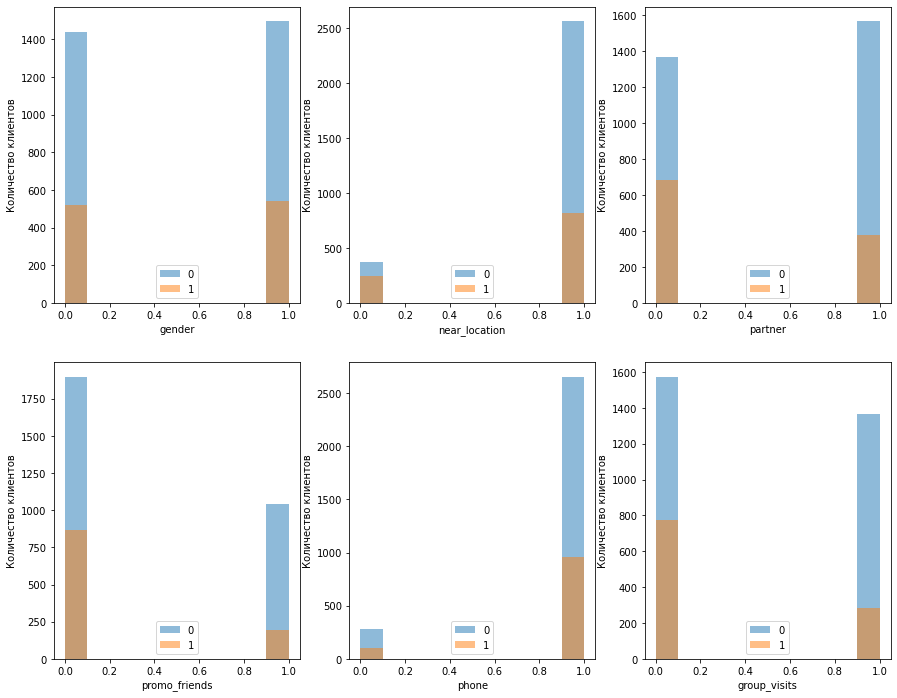

In [9]:
# визуализируем отличия для бинарных признаков
plt.figure(figsize=(15, 12))
for i in range(len(col_bi)-1):   
    ax = plt.subplot(2, 3, i+1)
    ax.hist(df.query('churn == 0')[col_bi[i]], alpha=0.5, label='0')
    ax.hist(df.query('churn == 1')[col_bi[i]], alpha=0.5, label='1')
    plt.xlabel(col_bi[i])
    plt.ylabel('Количество клиентов')
    plt.legend(loc='lower center')
plt.show()

Среди распределений бинарных признаков заметно, что чаще попадают в отток клиенты, которые проживают в другом районе, чей работодатель не сотрудничает с фитнес-центром и кто не ходит на групповые занятия.

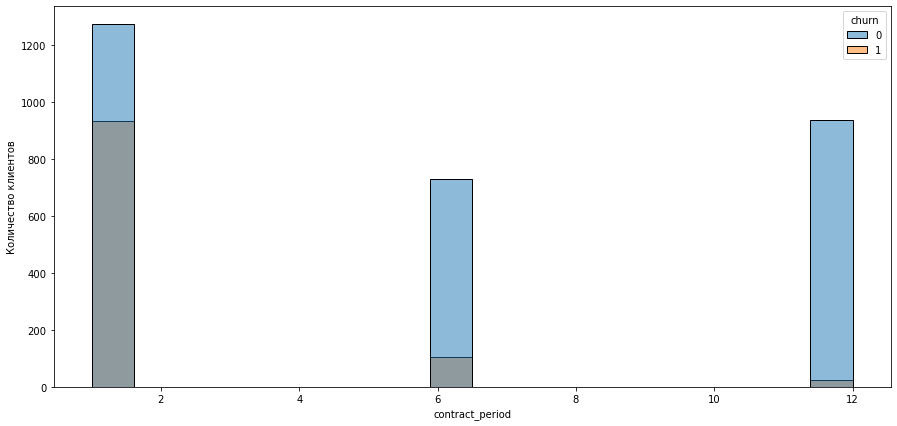

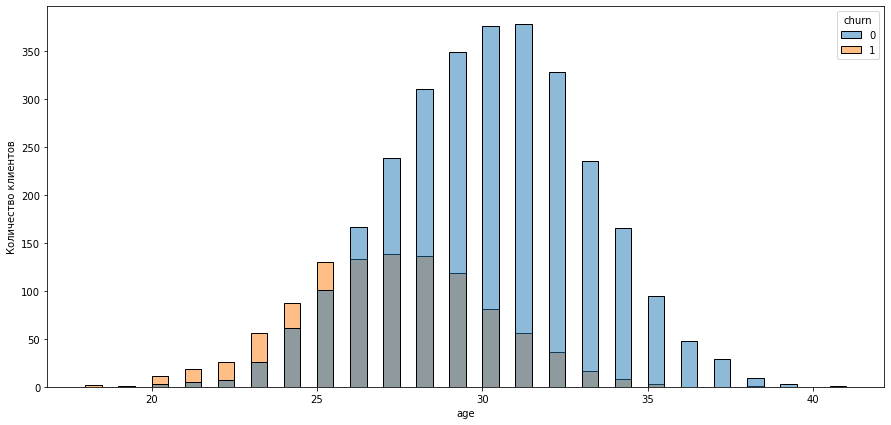

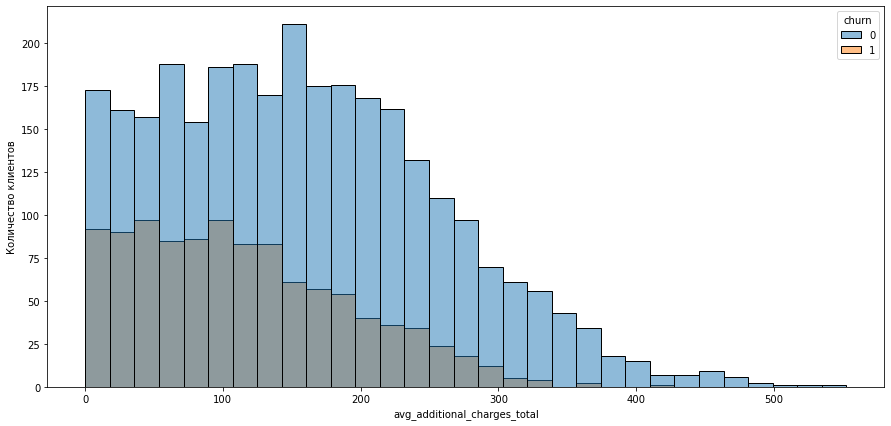

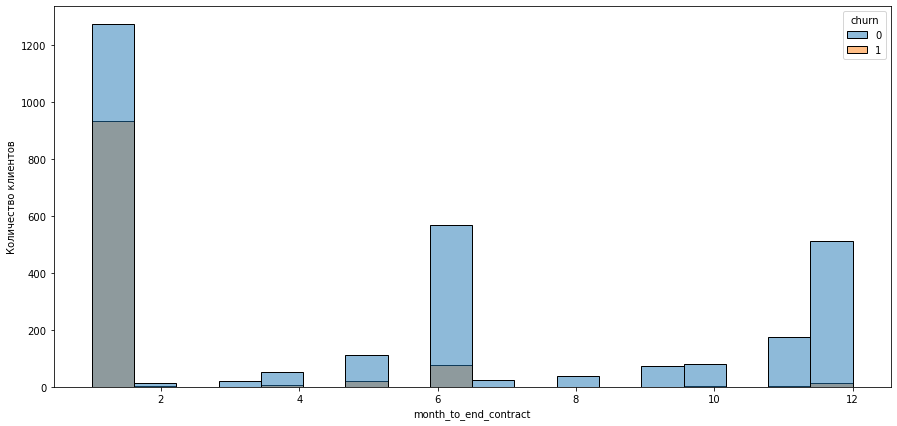

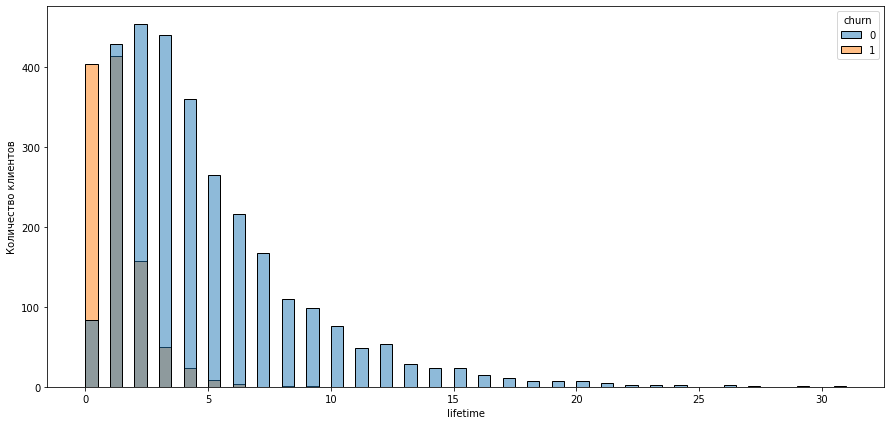

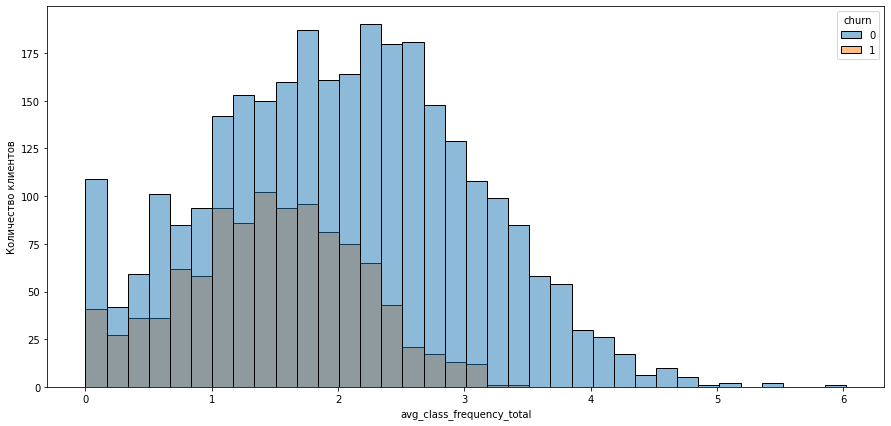

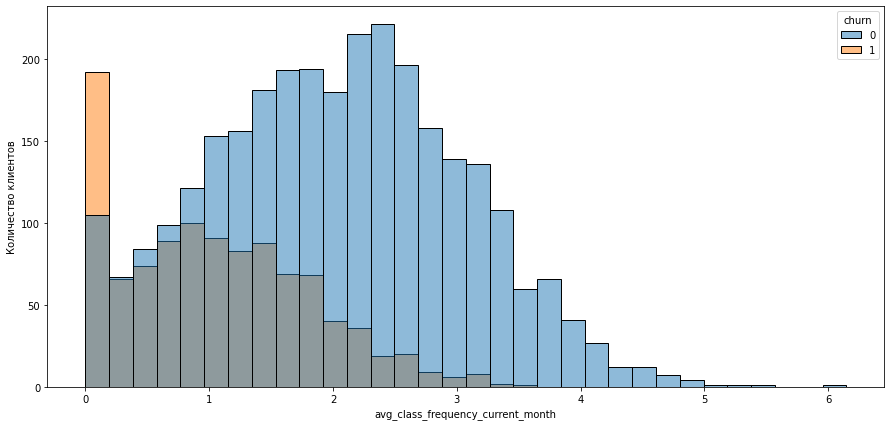

In [10]:
# визуализируем отличия
for col in col_nonbi:
    plt.figure(figsize=(15, 7))
    sns.histplot(x=col, data=df, hue='churn')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.show()

Среди распределений небинарных признаков заметно, что чаще попадают в отток клиенты, которые не ходили в текущий месяц, купили абонемент всего на 1 месяц, у которых остался всего месяц абонемента, кто пришел впервые не более 3 месяцев назад. Также эти клиенты в среднем немного моложе и немного реже посещают тренировки в целом. 

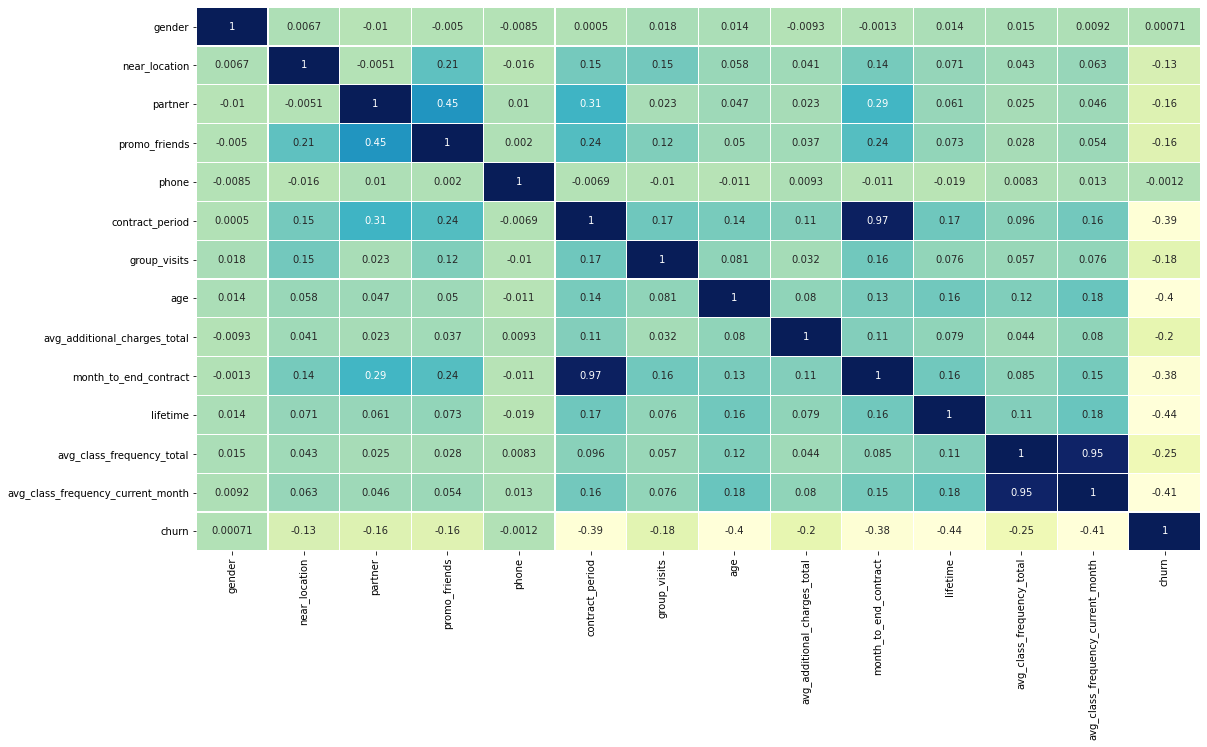

In [11]:
# матрица корреляций
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

Наиболее сильная корреляция заметна между `month_to_end_contract` и `contract_period`, а также между `avg_class_frequency_current_month` и `avg_class_frequency_total`. 

Вероятно, связь в первой паре вызвана тем, что для абонементов на 1 месяц это одно и то же число.

Связь во второй паре говорит о том, что люди в целом ходят более-менее стабильно на пртяжении всего действия абонемента. 

Сильной прямой корреляции между оттоком нет ни с какими признаками. 

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого используем модели логистической регрессии и случайного леса, посчитаем для оценки их качества метрики и выберем лучшую модель.

### Подготовка матрицы


In [12]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df.churn

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st =  scaler.fit_transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

In [13]:
def print_metrics(data_true, data_predicted):
    print('Доля правильных ответов:', accuracy_score(data_true, data_predicted))
    print('Точность:', precision_score(data_true, data_predicted))
    print('Полнота:', recall_score(data_true, data_predicted))
    print('F1-мера:', f1_score(data_true, data_predicted))
    print('ROC-AUC', roc_auc_score(data_true, data_predicted))

In [14]:
# задаем алгоритм для модели
model = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

# обучаем модель
model.fit(X_train_st, y_train)

y_pred = model.predict(X_test_st) #прогноз класса после обучения такой модели

# метрики для логистической регрессии
print_metrics(y_test, y_pred)

Доля правильных ответов: 0.935
Точность: 0.8921568627450981
Полнота: 0.8584905660377359
F1-мера: 0.875
ROC-AUC 0.9105378000256706


Величины метрик весьма неплохи, более 80% правильных прогнозов. 

С использованием L1-регуляции даже на пару процентных пунктов лучше. 

### Случайный лес

In [15]:
# задаем алгоритм для модели
model = RandomForestClassifier(random_state = 0)

# обучаем модель
model.fit(X_train_st, y_train)

y_pred = model.predict(X_test_st) #прогноз класса после обучения такой модели

# метрики для логистической регрессии
print_metrics(y_test, y_pred)

Доля правильных ответов: 0.9225
Точность: 0.875
Полнота: 0.8254716981132075
F1-мера: 0.8495145631067961
ROC-AUC 0.8914773456552433


Величины метрик для случайного леса также весьма неплохи, более 80% правильных прогнозов, но на несколько процентрных пунктов хуже, чем для логистической регрессии.

Признаем лучшей моделью логистическую регрессию.

## Кластеризация клиентов

### Иерархическая агломеративная кластеризация

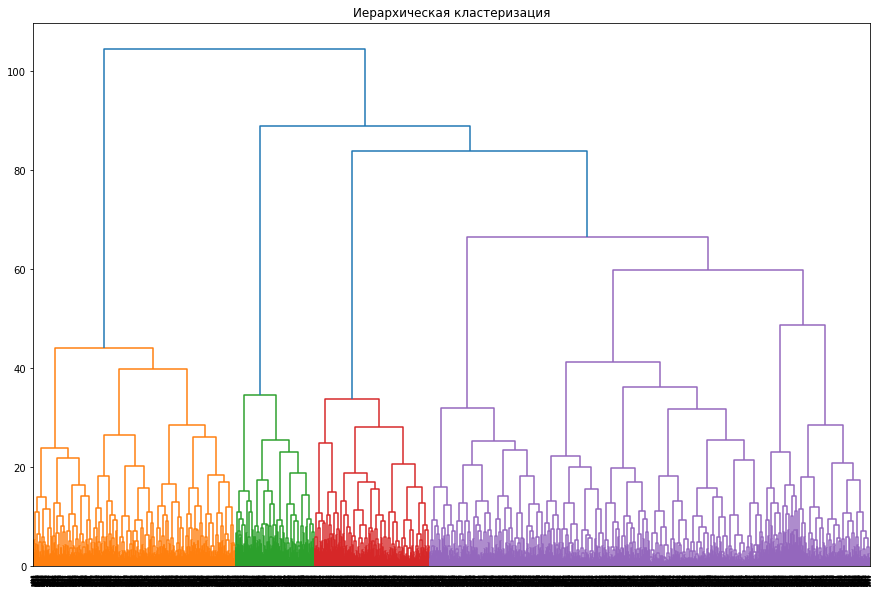

In [16]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании цветов полученного графика можно сделать вывод, что оптимальное количество кластеров - четыре. 

### K-Means

Зададим число кластеров, равное пяти. 

In [17]:
# количество кластеров было оговорено в задании
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [18]:
# выводим статистику по средним значениям всех признаков по кластеру
display(df.groupby('cluster_km').mean().T)

cluster_km                             0      1      2      3      4
gender                              0.52   0.48   0.56   0.51   0.50
near_location                       0.86   0.81   0.86   0.75   0.94
partner                             0.47   0.00   0.34   1.00   0.75
promo_friends                       0.31   0.09   0.20   0.45   0.54
phone                               0.00   1.00   1.00   1.00   1.00
contract_period                     4.79   1.87   2.73   2.55  11.35
group_visits                        0.43   0.33   0.45   0.30   0.56
age                                29.30  28.15  30.20  28.50  29.99
avg_additional_charges_total      143.96 131.37 164.58 129.81 164.56
month_to_end_contract               4.48   1.79   2.52   2.37  10.38
lifetime                            3.92   2.35   5.01   2.83   4.82
avg_class_frequency_total           1.85   1.33   2.93   1.36   2.03
avg_class_frequency_current_month   1.72   1.09   2.93   1.18   2.02
churn                               0.27   0.55   0.05   0.40   0.02

Самые преданные спортсмены - в кластерах 0 и 4. В обоих этих кластерах почти все клиенты живут рядом с клубом, чуть чаще остальных ходят на групповые занятия, больше других тратят на дополнительные услуги клуба, дольше являются клиентами и чаще тренируются - как за все всемя, так и в предыдущий месяц. К тому же в кластере 1 самая большая доля сотрудников компаний-партнеров, больше всего владельцев годовых абонементов, которые к тому же недавно открыты, эти клиенты чаще приведены друзьями. 

В кластере 3 самая большая доля оттока. Эти клиенты реже всего тренировались, меньше всех тратились на дополнительные услуги, и абонементы чаще всего покупали всего на месяц. 

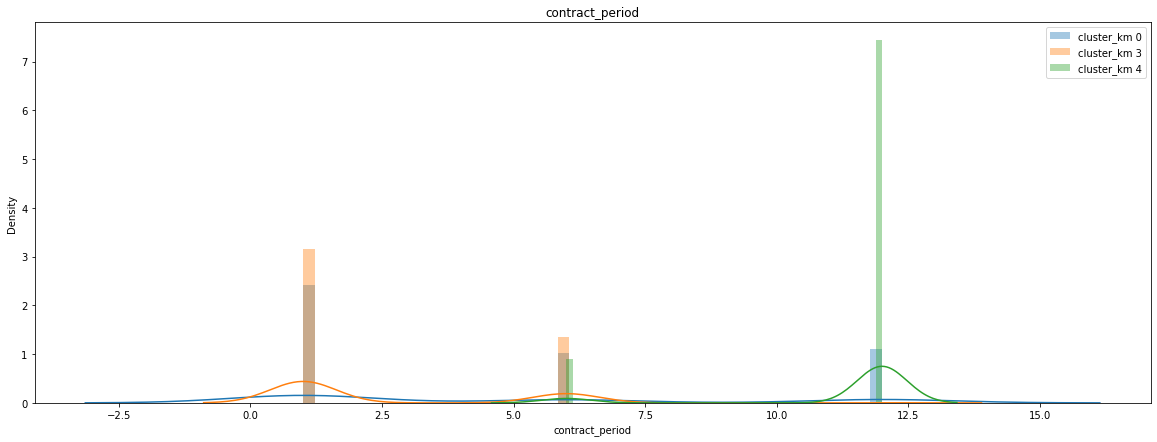

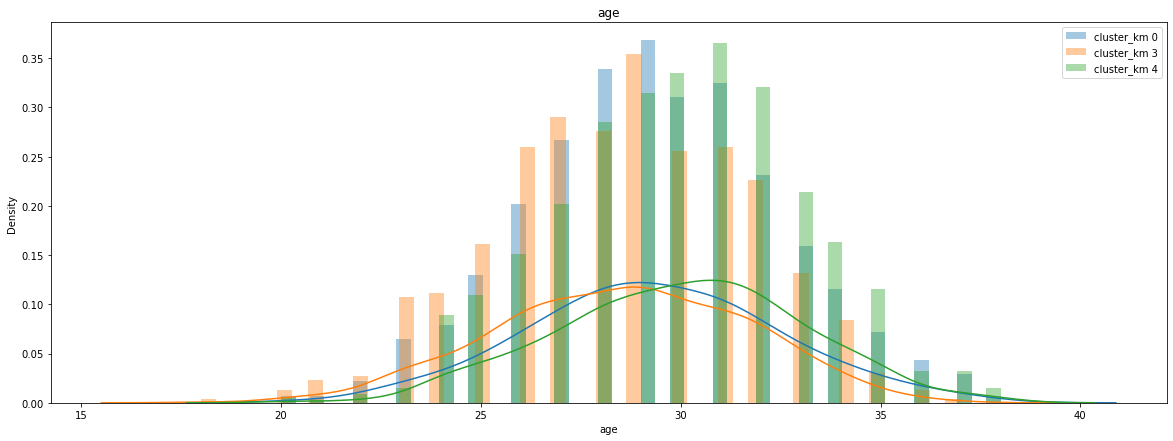

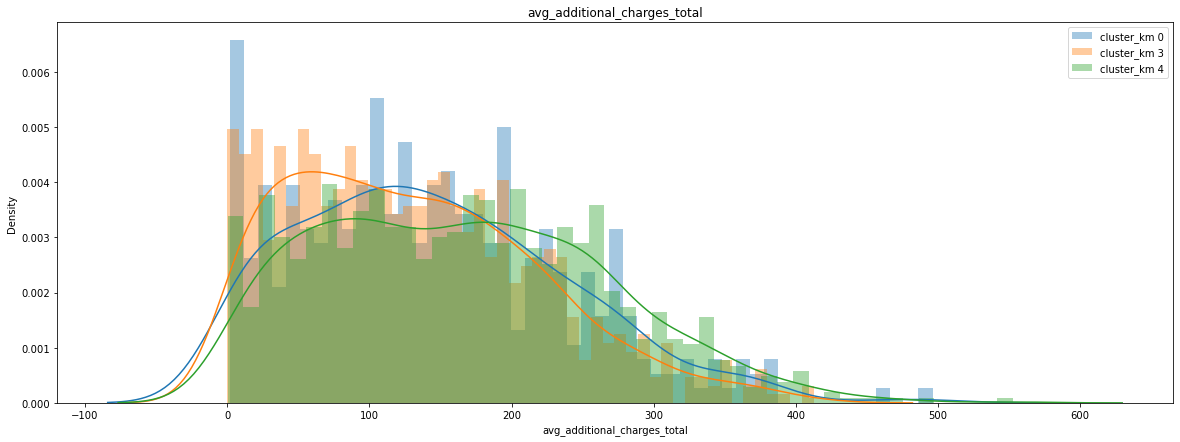

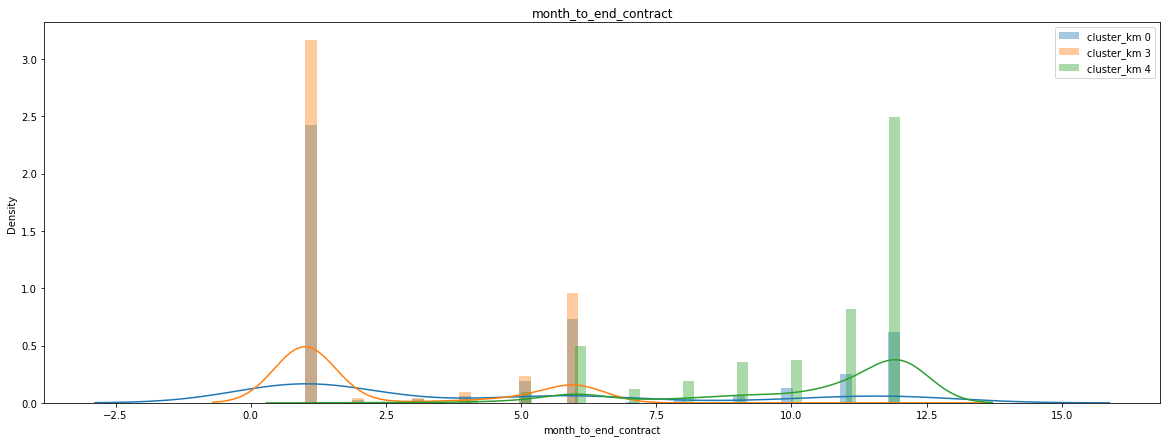

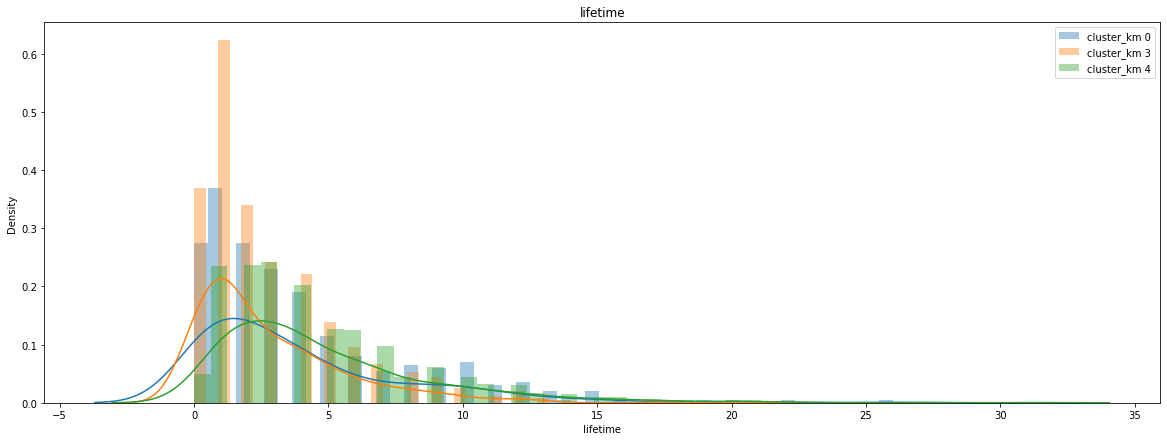

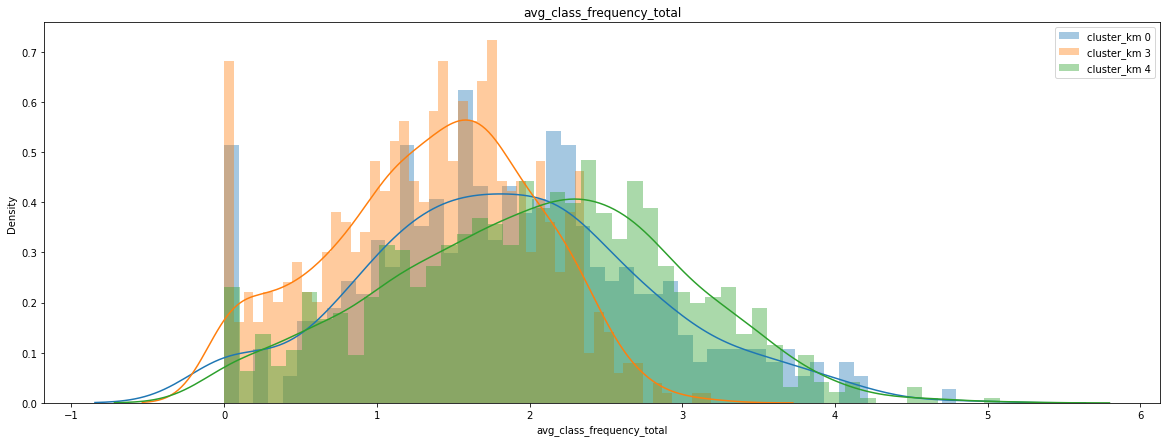

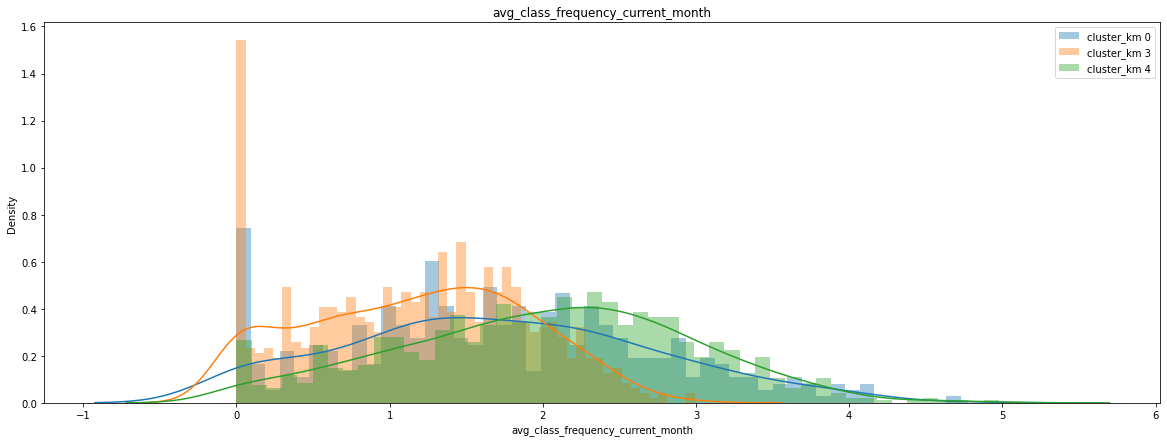

In [19]:
# построим графики распределения признаков в зависимости от кластера для выделяющихся трех кластеров - 0, 4 и 3
# при построении графиков для всех пяти кластеров они смешиваются в нечитаемую кашу
for col in col_nonbi:
    plt.figure(figsize=(20, 7))
    for i in [0, 3, 4]:
        sns.distplot(df.query('cluster_km == @i')[col], bins = 50, label='cluster_km ' + str(i))
    plt.title(col)    
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Графики иллюстрируют те же наблюдения: 

* В кластере 1 больше всего владельцев годовых абонементов, в 4 их мало, в 3 нет совсем
* В кластере 3 средний возраст немного ниже, чем в 1 и 4
* В кластере 3 немного меньше в среднем тратят на доп.услуги клуба
* В кластере 3 клиенты, которые пришли позже, чем в двух других кластерах
* В кластере 3 клиенты тренируются реже, чем в других кластерах, причем как на протяжении всего времени, так и в последний месяц. Также среди них наибольшее количество клиентов, которые вообще не посещали клуб в последний месяц. В кластере 4 таких нет совсем. 




## Выводы 

В ходе работы мы проанализировали анкеты четырех тысяч клиентов фитнес-клуба. 

На основании этих данных мы создали и обучили модели, позволяющие с высокой долей вероятности предсказывать, перестанет ли человек пользоваться услугами клуба или нет. 

Мы выделили 5 кластеров пользователей и проанализировали на основании их различий основные признаки, наиболее сильно свазанные с оттоком. Такими признаками являются:
* удаленность клуба от места жительства человека - те, кто живут близко, бросают занятия реже
* посещение групповых занятий - те, кто чаще ходят на них, бросают реже
* общая частота посещений - чем чаще человек ходит заниматься, тем выше вероятность, что он не броси занятия и дальше
* покупка дополнительных услуг - чем больше выручка от сопутствующих услуг, тем вероятнее, что человек продолжит заниматься (этот параметр кажется более связан с тем, что реже бросают клиенты с бОльшим стажем - и они просто успели потратить больше). 
* длительность абонемента - купившие годовой доступ бросают реже
* реже бросают клиенты более старшего возраста

Пол клиента, рекомендация от друга, наличие контактного номера телефона не показывают заметного влияния на отток.

Можно предложить следующие стратегии для взаимодействия с клиентами:
* придложение новым клиентам более выгодных длительных абонементов (полгода, год)
* внедрение абонементов, нацеленных только на посетителей групповых занятий - танцы или йога могут показаться более интересными, чем силовые упражнения, но закрепят привычку посещать клуб
* добавить к акции "Приведи друга" обратную сторону - бонус за приведенного друга, посетившего клуб, например, не менее 4 раз
* по завершении месячного абонемента напоминать новым клиентам о выгодных длительных абонементах